In [1]:
from google.colab import drive
import sys
drive.mount('/content/drive')
sys.path.append('/content/drive/MyDrive/Materias2023/Redes/TP1')

import helper

Mounted at /content/drive


# Fashion MNIST

In [2]:
from keras.datasets import fashion_mnist

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.ticker import StrMethodFormatter

from keras.models import Sequential, Model, clone_model
from keras.layers import Dense, Flatten, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

from keras.optimizers import SGD, Adagrad, RMSprop, Adadelta, Adam, Adamax, Nadam

from sklearn.metrics import f1_score, precision_score, recall_score, roc_curve, auc,  roc_auc_score
from sklearn.preprocessing import label_binarize


from keras.constraints import max_norm
from keras.initializers import glorot_normal, glorot_uniform, zeros, Constant, normal, he_normal, he_uniform
from keras.callbacks import EarlyStopping, ModelCheckpoint


In [3]:
(train_img, train_label), (test_img, test_label) = fashion_mnist.load_data()

# Normalization
train_img = train_img / 255.0
test_img = test_img / 255.0

val_img = train_img[50000:60000,:,:]
val_label = train_label[50000:60000]
train_img = train_img[0:50000,:,:]
train_label = train_label[0:50000]

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

4422102/4422102 [==============================] - 0s 0us/step


In [4]:
sparse_train_label = np.zeros([train_label.shape[0],10])
sparse_test_label = np.zeros([test_label.shape[0],10])
sparse_val_label = np.zeros([val_label.shape[0],10])

for idx in range(train_img.shape[0]):
   sparse_train_label[idx,train_label[idx]] = 1

for idx in range(test_img.shape[0]):
   sparse_test_label[idx,test_label[idx]] = 1

for idx in range(val_img.shape[0]):
   sparse_val_label[idx,val_label[idx]] = 1

## 1 - EDA

In [ ]:
print("Train img Shape: ", train_img.shape)

Train img Shape:  (50000, 28, 28)


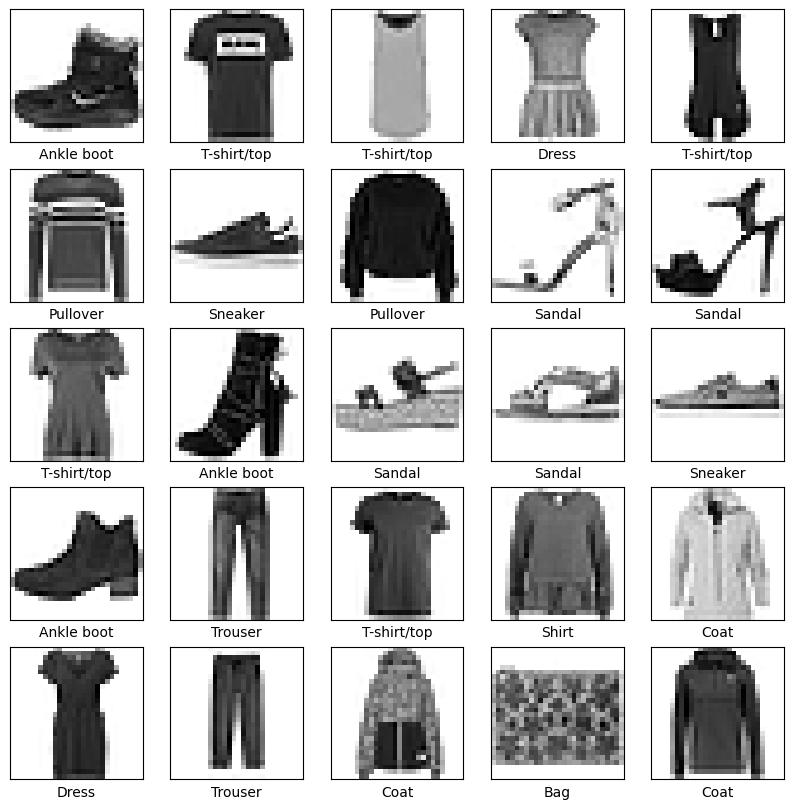

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_img[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_label[i]])
plt.show()

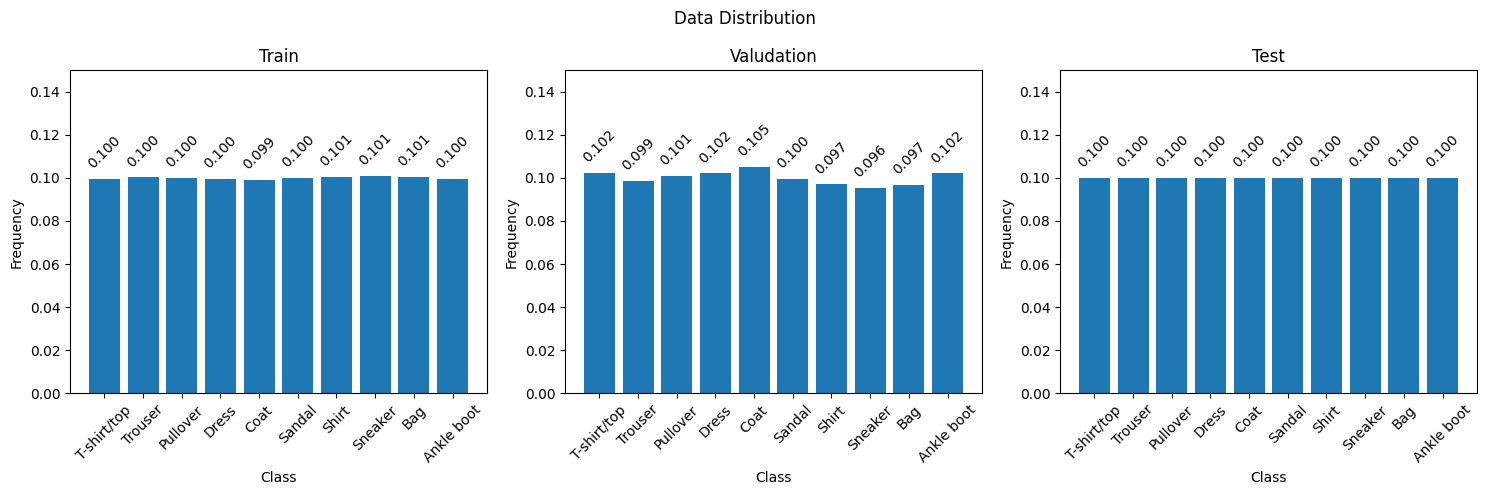

In [ ]:
# Calcular la frecuencia de cada clase
train_freq = np.bincount(train_label)/50000
val_freq = np.bincount(val_label)/10000
test_freq = np.bincount(test_label)/10000

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

helper.EDAGraph(train_freq, ax1, 'Train')
helper.EDAGraph(val_freq, ax2, 'Validation')
helper.EDAGraph(test_freq, ax3, 'Test')

plt.suptitle('Data Distribution')
plt.tight_layout()
plt.show()

Se puede observar que las **clases** se encuentran **balanceadas**.

## 2 - Modelos

###Softmax

In [ ]:
def model (model, learning_rate = 0.001, batch_size= 256, optimizer = Adam, verbose = True):
    model.add(Flatten(input_shape=(28, 28)))
    model.add(Dense(10, activation='softmax'))

    if (verbose): model.summary()

    model.compile(loss='categorical_crossentropy', optimizer= optimizer (learning_rate=learning_rate), metrics=['accuracy'])
    history = model.fit(train_img, sparse_train_label, validation_data=(val_img, sparse_val_label), epochs=15, batch_size = batch_size, verbose = verbose)
    
    return history 

model_base_sm = Sequential()
model(model_base_sm)

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_26 (Flatten)        (None, 784)               0         
                                                                 
 dense_76 (Dense)            (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
196/196 [==============================] - 1s 4ms/step - loss: 0.9326 - accuracy: 0.6931 - val_loss: 0.6553 - val_accuracy: 0.7839
Epoch 2/15
196/196 [==============================] - 1s 3ms/step - loss: 0.5955 - accuracy: 0.8055 - val_loss: 0.5554 - val_accuracy: 0.8140
Epoch 3/15
196/196 [==============================] - 1s 4ms/step - loss: 0.5316 - accuracy: 0.8256 - val_loss: 0.5205 - val_accuracy: 0.8227
Epoch 4/15
196/196 [=

####Métricas Secundarias

El **promedio macro** calcula las métricas por clase y luego las promedia sin considerar el desbalance de clases (pondera todas las clases de igual manera).

El **promedio micro**, por otro lado, calcula las métricas globalmente considerando todas las clases como una sola (pondera las clases de acuerdo a su frecuencia en los datos).

En este caso, como las clases están relativamente balanceadas, se utilizará el **promedio macro**, el cual dará una visión equitativa del rendimiento del modelo para cada clase individualmente.

In [ ]:
binary_labels = label_binarize(test_label, classes=np.unique(test_label))

# Calcular las métricas de evaluación
predictions = model_base_sm.predict(test_img, verbose = False)
loss, accuracy = model_base_sm.evaluate(test_img, sparse_test_label, verbose=False)
f1 = f1_score(test_label, np.argmax(predictions, axis=1), average='weighted')
precision = precision_score(test_label, np.argmax(predictions, axis=1), average='weighted')
recall = recall_score(test_label, np.argmax(predictions, axis=1), average='weighted')
roc_auc = roc_auc_score(binary_labels, predictions, average='macro')

# Imprimir los resultados
print('Loss:', round(loss, 4))
print('Accuracy:', round(accuracy,4))
print('F1-score:', round(f1,4))
print('Precision:', round(precision,4))
print('Recall:', round(recall,4))
print('AUC-ROC (Macro-Average):', round(roc_auc,4))

Loss: 0.454
Accuracy: 0.8421
F1-score: 0.8399
Precision: 0.8407
Recall: 0.8421
AUC-ROC (Macro-Average): 0.9829


Como el softmax es un modelo de alto sesgo de referencia y su desempeño es inferior al de una red MLP, se tomó la decisión de analizar las variaciones de los diferentes hiperparámetros directamente para esta última red. 

### MLP

#### Modelo Original

Se eligió un modelo que tuviera un alto acurracy, pero que a la vez fuera rápido de compilar para las pruebas posteriores.

In [ ]:
def model (model, learning_rate = 0.001, batch_size= 128, optimizer = Adam, activation = 'relu', dropout_rate = 0.2, batch_normalization = True, weight_init = 'glorot_normal', verbose = True):
    model.add(Flatten(input_shape=(28, 28)))
    model.add(Dense(256, activation = activation, kernel_initializer = weight_init))
    model.add(Dropout(dropout_rate))
    model.add(Dense(128, activation = activation, kernel_initializer = weight_init))
    model.add(Dropout(dropout_rate))
    if (batch_normalization): model.add(BatchNormalization())
    model.add(Dense(10, activation='softmax'))

    early_stop = EarlyStopping(monitor='val_accuracy', patience=10)

    if (verbose): model.summary()

    epochs=100

    model.compile(loss='categorical_crossentropy', optimizer= optimizer (learning_rate=learning_rate), metrics=['accuracy'])
    history = model.fit(train_img, sparse_train_label, validation_data=(val_img, sparse_val_label), epochs=epochs, batch_size = batch_size, callbacks = [early_stop], verbose = verbose)
    
    if(early_stop.stopped_epoch):
        stop_epoch = early_stop.stopped_epoch + 1
    else:
        stop_epoch = epochs
        
    return history, stop_epoch 

In [ ]:
model_base = Sequential()
model(model_base)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 256)               200960    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                        

(<keras.callbacks.History at 0x7f5b1034a6e0>, 50)

#####Métricas Secundarias 

In [ ]:
binary_labels = label_binarize(test_label, classes=np.unique(test_label))

# Calcular las métricas de evaluación
predictions = model_base.predict(test_img)
loss, accuracy = model_base.evaluate(test_img, sparse_test_label)
f1 = f1_score(test_label, np.argmax(predictions, axis=1), average='weighted')
precision = precision_score(test_label, np.argmax(predictions, axis=1), average='weighted')
recall = recall_score(test_label, np.argmax(predictions, axis=1), average='weighted')
roc_auc = roc_auc_score(binary_labels, predictions, average='macro')

# Imprimir los resultados
print('Loss:', loss)
print('Accuracy:', accuracy)
print('F1-score:', f1)
print('Precision:', precision)
print('Recall:', recall)
print('AUC-ROC (Macro-Average):', roc_auc)


313/313 [==============================] - 1s 3ms/step - loss: 0.3668 - accuracy: 0.8896
Loss: 0.3667859733104706
Accuracy: 0.8895999789237976
F1-score: 0.8895394370974623
Precision: 0.8904819413848385
Recall: 0.8896
AUC-ROC (Macro-Average): 0.9907676444444447


#####Promedio de Probabilidades

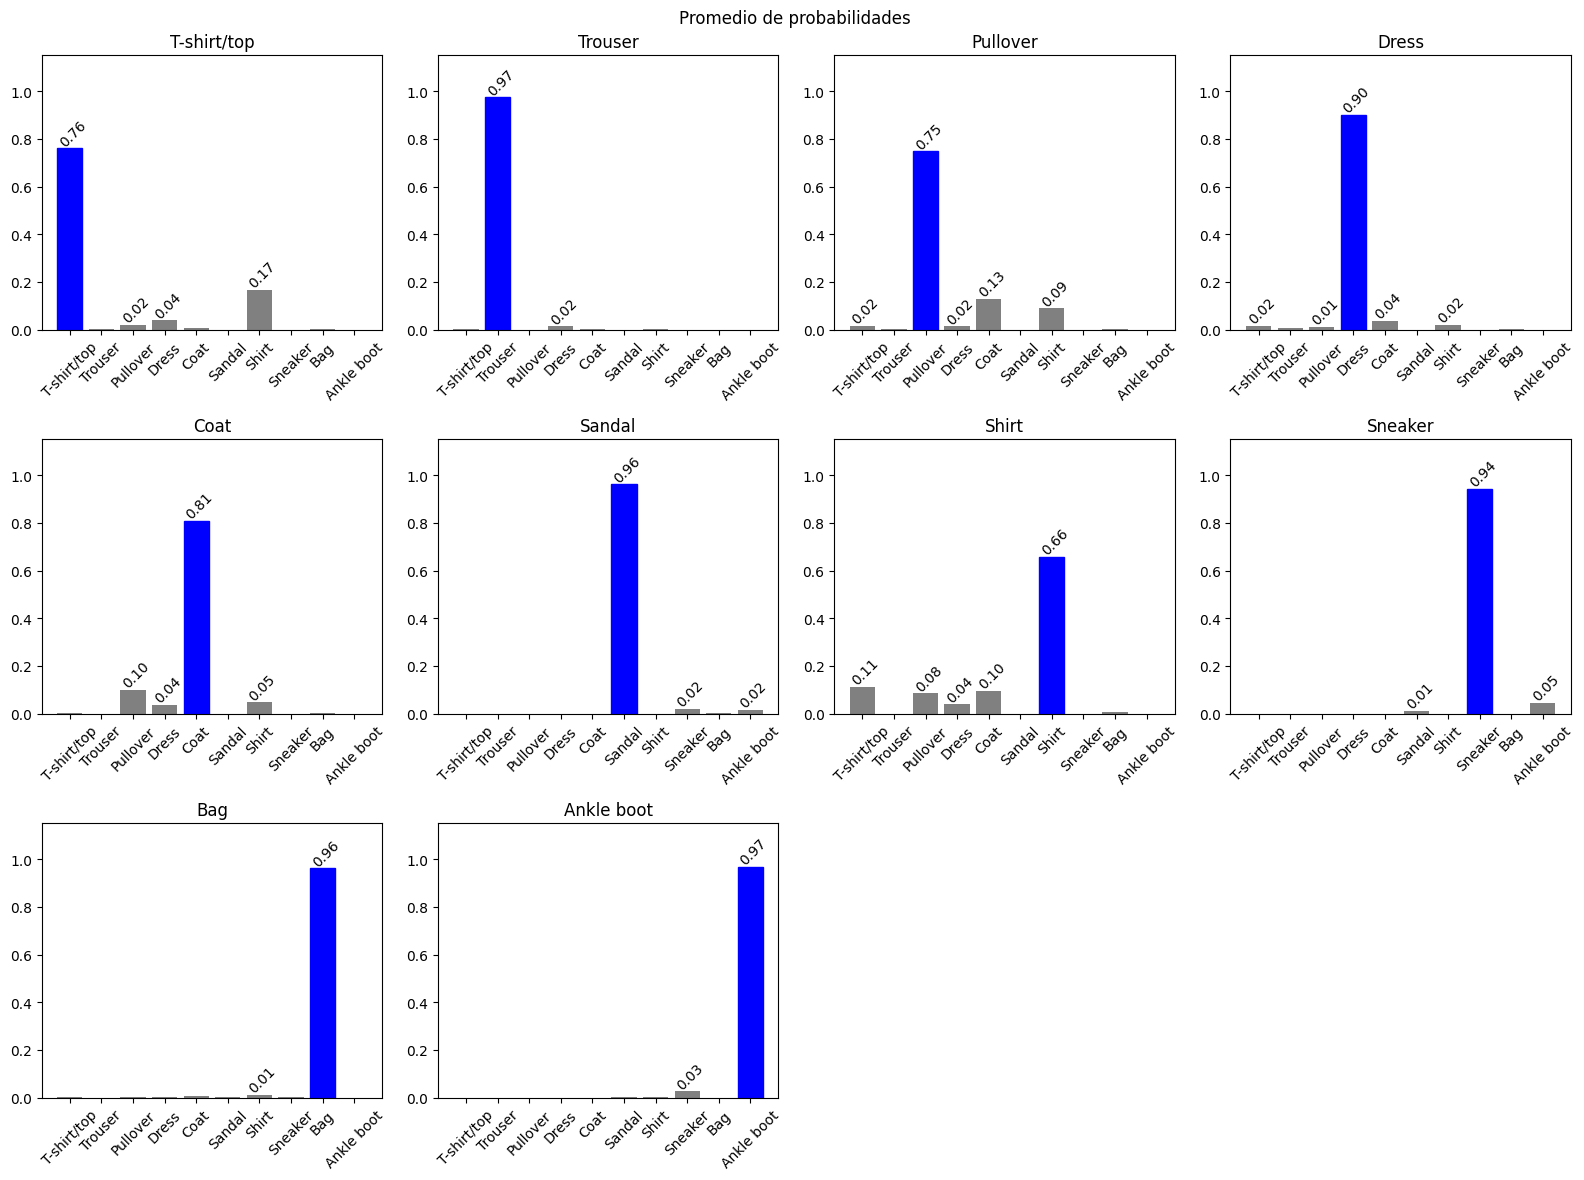

In [ ]:
import helper
averages = helper.class_average(predictions,test_label)
i = 0
num_rows = 3
num_cols = 4
num_images = num_rows*num_cols
plt.figure(figsize=(4*num_cols, 4*num_rows))
for i in range(num_images):
    if i+1>10: continue
    plt.subplot(num_rows, num_cols, i+1)
    helper.plot_value_array(i, averages)

plt.suptitle("Promedio de probabilidades")
plt.tight_layout()
plt.show()

Aquí se puede observar como **shirt** y **pullover** son una de las que **mayores problemas** trae a la hora de distinguirlas de otras clases, mientras que los diferentes **calzados** son **más simples** de distinguir.

Se fueron variando los diferentes hiperparámetros, de a uno a la vez. Por cada variación se fue **preservando el mejor valor** de los hiperparámetros anteriores. Se graficó la cantidad de epochs y el **accuracy de validation**.

#### Variación de Learning_Rate

In [ ]:
model_lr = {}
history_lr = {}
epoch_lr = {}
learning_rates = [0.00001*(5**i) for i in range(1, 8)]

for i in range(7):
    model_lr[i] = Sequential()
    history_lr[i], epoch_lr[i] = model(model_lr[i], learning_rates[i], verbose = False)
    print ('N°', i, ', Learning Rate:', learning_rates[i], ', Accuracy:', history_lr[i].history['accuracy'][-1])

N° 0 , Learning Rate: 5e-05 , Accuracy: 0.929099977016449
N° 1 , Learning Rate: 0.00025 , Accuracy: 0.9489799737930298
N° 2 , Learning Rate: 0.00125 , Accuracy: 0.9412000179290771
N° 3 , Learning Rate: 0.00625 , Accuracy: 0.9087399840354919
N° 4 , Learning Rate: 0.03125 , Accuracy: 0.9014400243759155
N° 5 , Learning Rate: 0.15625 , Accuracy: 0.8449400067329407
N° 6 , Learning Rate: 0.7812500000000001 , Accuracy: 0.7752599716186523


313/313 [==============================] - 2s 5ms/step - loss: 13.9200 - accuracy: 0.8125


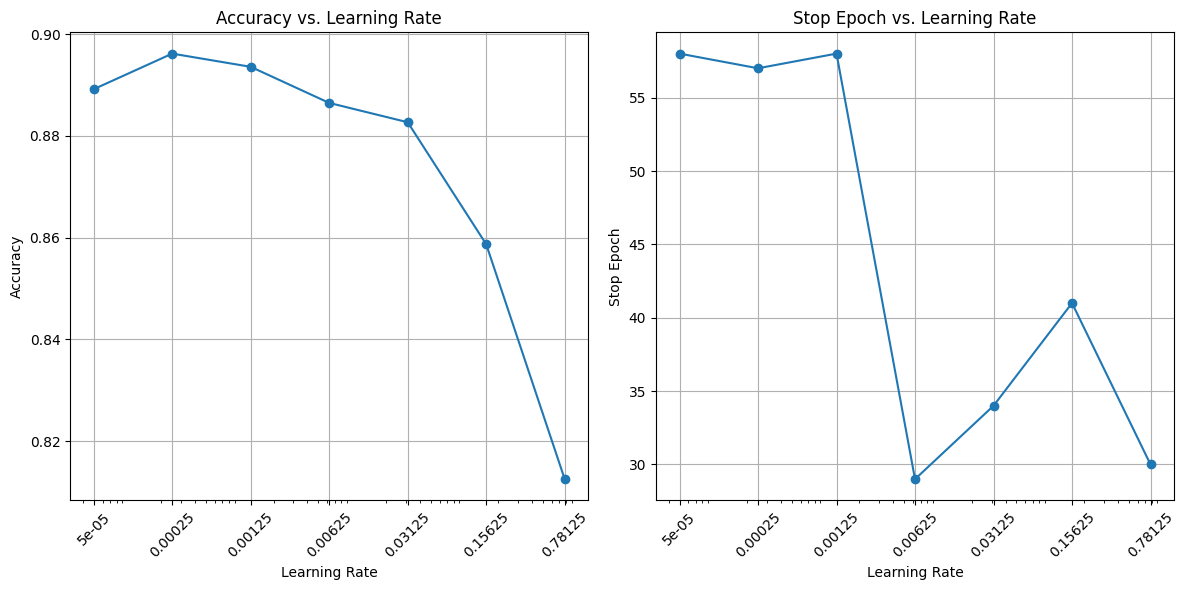

In [ ]:
accuracy_lr={}
for i in range(7):
    loss, accuracy = model_lr[i].evaluate(test_img, sparse_test_label)
    accuracy_lr[i] = accuracy

accuracy_values = [accuracy_lr[i] for i in range(7)]
stop_epochs = [epoch_lr[i] for i in range(7)]

helper.acc_epoch_graph (learning_rates, 'Learning Rate', accuracy_values, stop_epochs, log=True)

Para valores de learning rate muy pequeños o muy grandes, el acurracy disminuye notablemente. También disminuye la cantidad de epochs a mayor learning rate, ya que convergerá mas rápido pero a un peor valor. Se tomó como valor óptimo 0.00025, aunque por cuestiones de tiempo de compilación luego se tomará un learning rate de 0.00125.

####Variación de Batch Size

In [ ]:
model_bs = {}
history_bs = {}
epoch_bs = {}
batch_size = [16, 32, 64, 128, 256, 512, 1024, 2048]

for i in range(8):
    model_bs[i] = Sequential()
    history_bs[i], epoch_bs[i] = model(model_bs[i], batch_size=batch_size[i], learning_rate = 0.00025,verbose = False)
    print ('N°', i, ', Batch Size:', batch_size[i], ', Accuracy:', history_bs[i].history['accuracy'][-1])

N° 0 , Batch Size: 16 , Accuracy: 0.9444400072097778
N° 1 , Batch Size: 32 , Accuracy: 0.9362599849700928
N° 2 , Batch Size: 64 , Accuracy: 0.946940004825592
N° 3 , Batch Size: 128 , Accuracy: 0.9466400146484375
N° 4 , Batch Size: 256 , Accuracy: 0.9548799991607666
N° 5 , Batch Size: 512 , Accuracy: 0.9506800174713135
N° 6 , Batch Size: 1024 , Accuracy: 0.9425600171089172
N° 7 , Batch Size: 2048 , Accuracy: 0.9367200136184692


313/313 [==============================] - 1s 4ms/step - loss: 0.3315 - accuracy: 0.8883


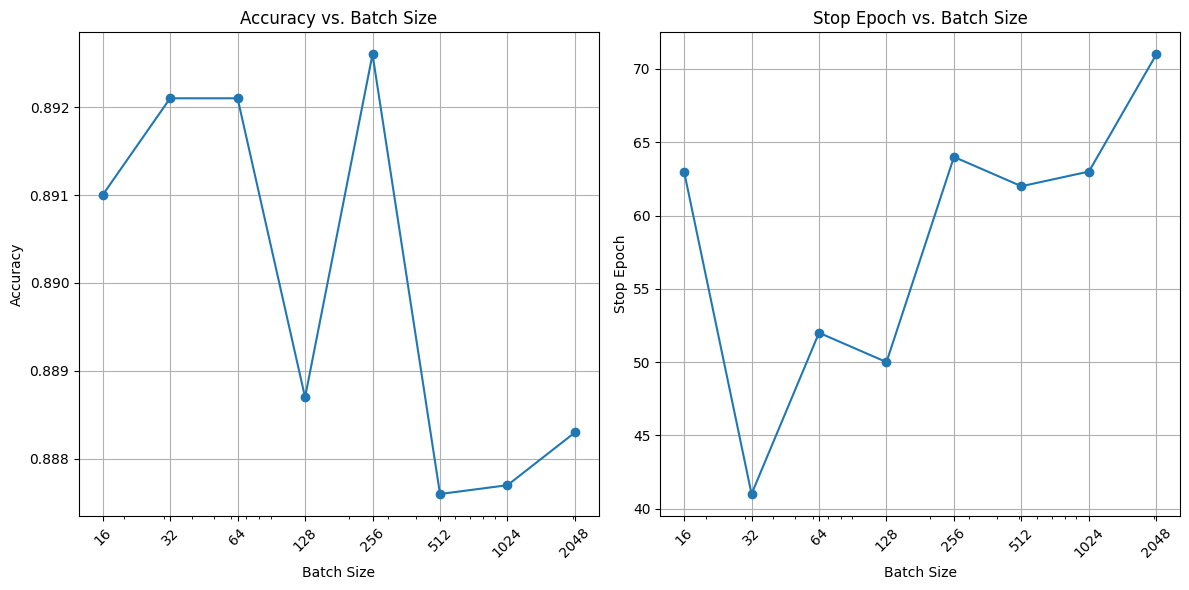

In [ ]:
accuracy_bs={}
for i in range(8):
    loss, accuracy = model_bs[i].evaluate(test_img, sparse_test_label)
    accuracy_bs[i] = accuracy

accuracy_values = [accuracy_bs[i] for i in range(8)]
stop_epochs = [epoch_bs[i] for i in range(8)]

helper.acc_epoch_graph (batch_size, 'Batch Size', accuracy_values, stop_epochs, log=True)

Aunque no lo parezca, en general los valores de acurracy son muy similares en todos los casos. A pesar de que cuanto mayor es el batch size, habrá mayor cantidad de epochs, también habrá una mayor velocidad de entrenamiento. Por lo tanto se optó por utilizar un batch size de 256 que era el de mayor accuracy.

####Variación de Optimizadores

In [ ]:
model_op = {}
history_op = {}
epoch_op = {}
optim = [Adadelta, SGD, Adagrad, Adam, Adamax, RMSprop, Nadam]

for i in range(7):
    model_op[i] = Sequential()
    history_op[i], epoch_op[i] = model(model_op[i], optimizer=optim[i], learning_rate = 0.00125, batch_size = 256, verbose = False)
    print ('N°', i, ', Optimizer:', optim[i], ', Accuracy:', history_op[i].history['accuracy'][-1])

N° 0 , Optimizer: <class 'keras.optimizers.legacy.adadelta.Adadelta'> , Accuracy: 0.7905799746513367
N° 1 , Optimizer: <class 'keras.optimizers.legacy.gradient_descent.SGD'> , Accuracy: 0.853600025177002
N° 2 , Optimizer: <class 'keras.optimizers.legacy.adagrad.Adagrad'> , Accuracy: 0.869159996509552
N° 3 , Optimizer: <class 'keras.optimizers.legacy.adam.Adam'> , Accuracy: 0.9241200089454651
N° 4 , Optimizer: <class 'keras.optimizers.legacy.adamax.Adamax'> , Accuracy: 0.957360029220581
N° 5 , Optimizer: <class 'keras.optimizers.legacy.rmsprop.RMSprop'> , Accuracy: 0.9470400214195251
N° 6 , Optimizer: <class 'keras.optimizers.legacy.nadam.Nadam'> , Accuracy: 0.9434800148010254


313/313 [==============================] - 1s 4ms/step - loss: 0.3794 - accuracy: 0.8850


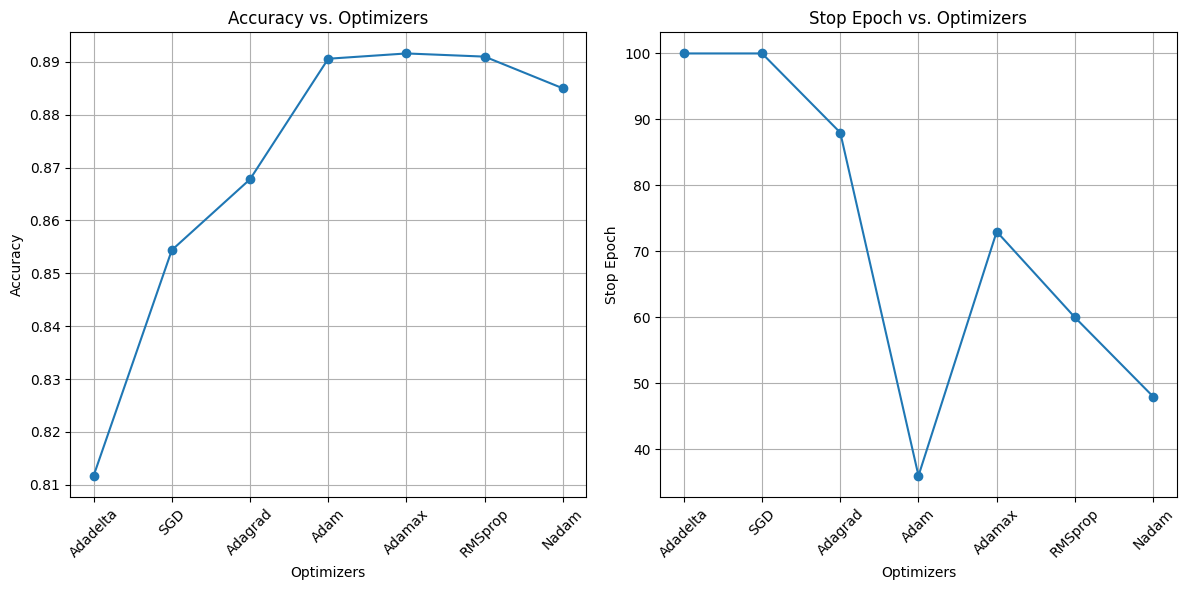

In [ ]:
accuracy_op={}
for i in range(7):
    loss, accuracy = model_op[i].evaluate(test_img, sparse_test_label)
    accuracy_op[i] = accuracy

accuracy_values = [accuracy_op[i] for i in range(7)]
stop_epochs = [epoch_op[i] for i in range(7)]

optim = ['Adadelta', 'SGD', 'Adagrad', 'Adam', 'Adamax', 'RMSprop', 'Nadam']
helper.acc_epoch_graph (optim, 'Optimizers', accuracy_values, stop_epochs, log=False)

Se puede notar una gran diferencia en el accuracy y cantidad de epochs de algunos de los optimizadores más usados, siendo Adadelta el peor y Adam el que mejor se ajusta a este modelo, debido a su gran  acurracy y bajo número de epochs.

####Variación de Activaciones

In [ ]:
model_act = {}
history_act = {}
epoch_act = {}
activation = ['sigmoid', 'tanh', 'softplus', 'elu', 'selu', 'relu', 'leaky_relu', 'softmax']

for i in range(8):
    model_act[i] = Sequential()
    history_act[i], epoch_act[i] = model(model_act[i], activation=activation[i],  learning_rate = 0.00125, batch_size = 256, optimizer = Adam, verbose = False)
    print ('N°', i, ', Activation:', activation[i], ', Accuracy:', history_act[i].history['accuracy'][-1])

N° 0 , Activation: sigmoid , Accuracy: 0.9231200218200684
N° 1 , Activation: tanh , Accuracy: 0.9343799948692322
N° 2 , Activation: softplus , Accuracy: 0.940559983253479
N° 3 , Activation: elu , Accuracy: 0.939300000667572
N° 4 , Activation: selu , Accuracy: 0.9393200278282166
N° 5 , Activation: relu , Accuracy: 0.9387000203132629
N° 6 , Activation: leaky_relu , Accuracy: 0.9222599864006042
N° 7 , Activation: softmax , Accuracy: 0.8464599847793579


313/313 [==============================] - 1s 3ms/step - loss: 0.4174 - accuracy: 0.8559


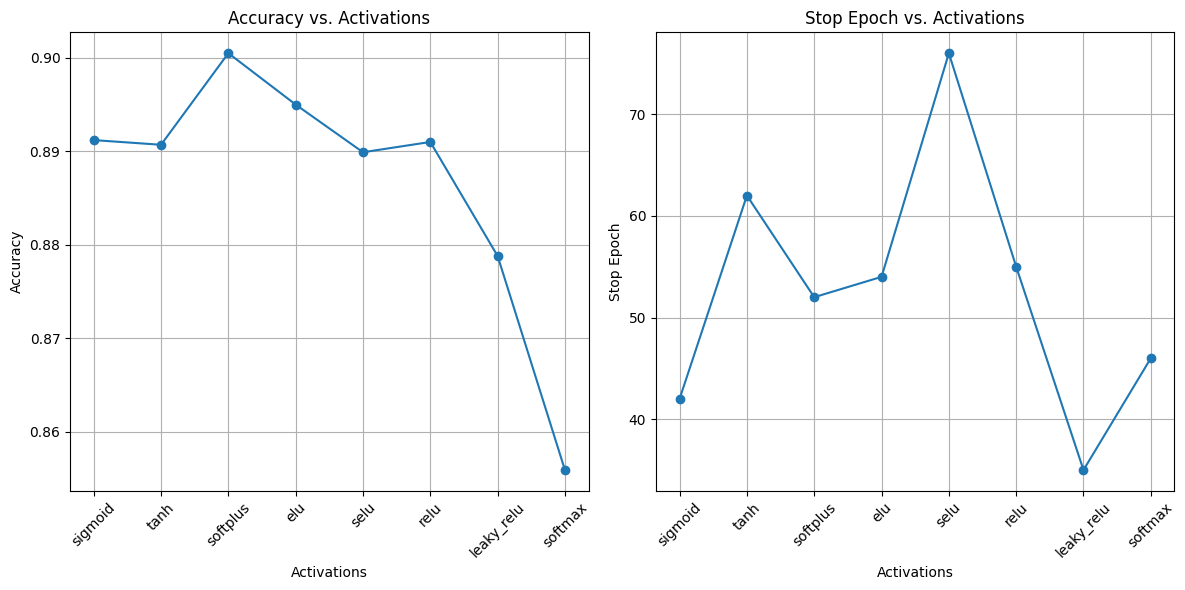

In [ ]:
accuracy_act={}
for i in range(8):
    loss, accuracy = model_act[i].evaluate(test_img, sparse_test_label)
    accuracy_act[i] = accuracy

accuracy_values = [accuracy_act[i] for i in range(8)]
stop_epochs = [epoch_act[i] for i in range(8)]

helper.acc_epoch_graph (activation, 'Activations', accuracy_values, stop_epochs, log=False)

En general el acurracy de todas las funciones de activación resultó ser similar, con la excepción de la leaky relu y la softmax, siendo esta última la peor. Mientras que leaky relu tiene la ventaja de requerir una pequeña cantidad de epochs, ésto no es suficiente para obtener el mejor modelo. Por otro lado la softplus predomina en la accuracy y tiene un valor aceptable de cantidad de epochs.

####Variación de Drop Out

In [ ]:
model_drop = {}
history_drop = {}
epoch_drop = {}
drop_out = [0.1, 0.2, 0.3, 0.5, 0.7, 0.9]

for i in range(6):
    model_drop[i] = Sequential()
    history_drop[i], epoch_drop[i] = model(model_drop[i], dropout_rate=drop_out[i], learning_rate = 0.00125, batch_size = 256, optimizer = Adam, activation='softplus', verbose = False)
    print ('N°', i, ', Drop Out:', drop_out[i], ', Accuracy:', history_drop[i].history['accuracy'][-1])

N° 0 , Drop Out: 0.1 , Accuracy: 0.9518799781799316
N° 1 , Drop Out: 0.2 , Accuracy: 0.9400799870491028
N° 2 , Drop Out: 0.3 , Accuracy: 0.9398800134658813
N° 3 , Drop Out: 0.5 , Accuracy: 0.900879979133606
N° 4 , Drop Out: 0.7 , Accuracy: 0.8752800226211548
N° 5 , Drop Out: 0.9 , Accuracy: 0.7013800144195557


313/313 [==============================] - 1s 4ms/step - loss: 0.5419 - accuracy: 0.8276


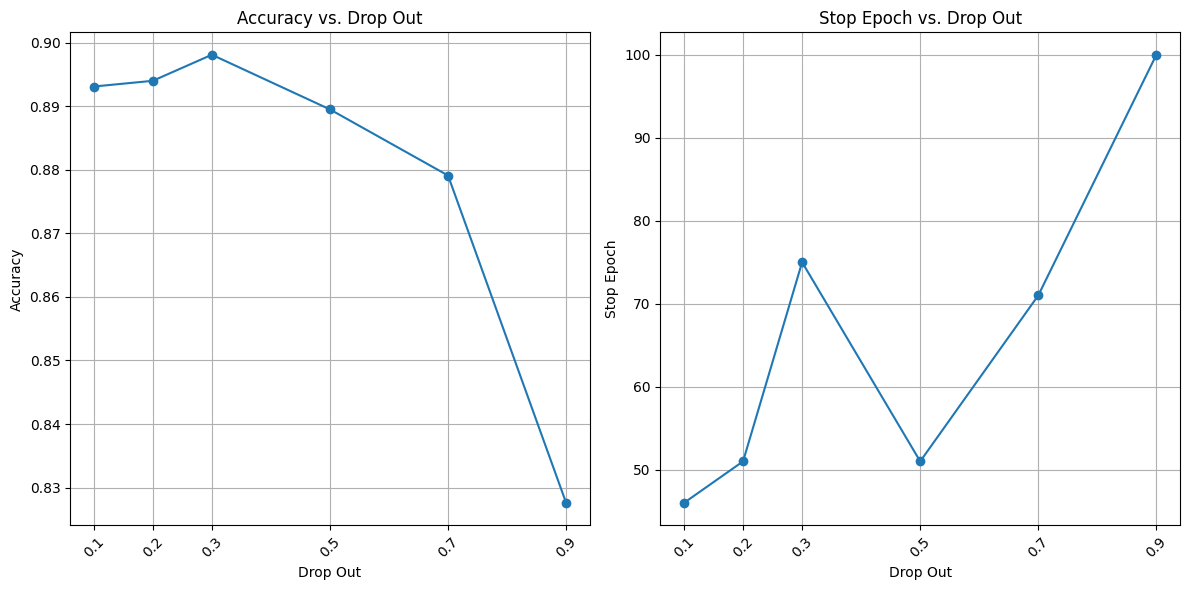

In [ ]:
accuracy_drop={}
for i in range(6):
    loss, accuracy = model_drop[i].evaluate(test_img, sparse_test_label)
    accuracy_drop[i] = accuracy

accuracy_values = [accuracy_drop[i] for i in range(6)]
stop_epochs = [epoch_drop[i] for i in range(6)]

helper.acc_epoch_graph (drop_out, 'Drop Out', accuracy_values, stop_epochs, log=False)

Si bien es necesario un valor de drop out elevado para que entrenen todas las neuronas, un valor demasiado elevado terminará perjudicando al sistema. No solo lo perjudica en la reducción de su acurracy, sino que también aumentará la cantidad de epochs necesarios para converger. Es por esto que se optó por un dropout de 0.2 que tiene un elevado accuracy y una de las menores cantidades de epochs necesarios.

####Variación de Batch Normalization

In [ ]:
model_bn = {}
history_bn = {}
epoch_bn = {}
batch_normalization = [True, False]

for i in range(2):
    model_bn[i] = Sequential()
    history_bn[i], epoch_bn[i] = model(model_bn[i], batch_normalization=batch_normalization[i], learning_rate = 0.00125, batch_size = 256, optimizer = Adam, activation='softplus', dropout_rate=0.3, verbose = False)
    print ('N°', i, ', Batch Normalization:', batch_normalization[i], ', Accuracy:', history_bn[i].history['accuracy'][-1])

N° 0 , Batch Normalization: True , Accuracy: 0.9397000074386597
N° 1 , Batch Normalization: False , Accuracy: 0.9421799778938293


313/313 [==============================] - 1s 3ms/step - loss: 0.3866 - accuracy: 0.8969


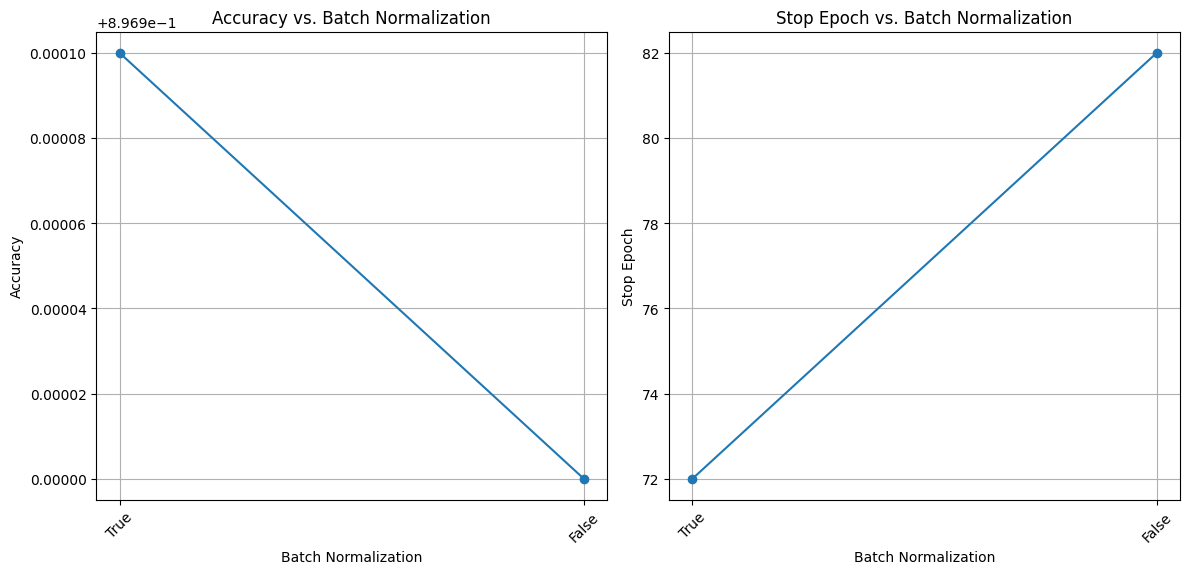

In [ ]:
accuracy_bn={}
for i in range(2):
    loss, accuracy = model_bn[i].evaluate(test_img, sparse_test_label)
    accuracy_bn[i] = accuracy

accuracy_values = [accuracy_bn[i] for i in range(2)]
stop_epochs = [epoch_bn[i] for i in range(2)]

batch_normalization = ['True', 'False']
helper.acc_epoch_graph (batch_normalization, 'Batch Normalization', accuracy_values, stop_epochs, log=False)

En este caso no hay diferencias significativas entre ambas situaciones, comportándose de manera similar. Sin embargo, para redes de mayor cantidad de capas y neuronas esta diferencia crecerá, favoreciendo la utilización de batch normalization.

####Variación de Inicialización de Pesos

In [ ]:
model_wi = {}
history_wi = {}
epoch_wi = {}
weight_init = ['glorot_normal', 'glorot_uniform', Constant(0.5), normal(0,1,seed=42), 'he_normal', 'he_uniform', 'zeros']

for i in range(7):
    model_wi[i] = Sequential()
    history_wi[i], epoch_wi[i] = model(model_wi[i], weight_init=weight_init[i], learning_rate = 0.00125, batch_size = 256, optimizer = Adam, activation='softplus', dropout_rate=0.3, batch_normalization = False, verbose = False)
    print ('N°', i, ', Weight Initializer:', weight_init[i], ', Accuracy:', history_wi[i].history['accuracy'][-1])

N° 0 , Weight Initializer: glorot_normal , Accuracy: 0.9382200241088867
N° 1 , Weight Initializer: glorot_uniform , Accuracy: 0.9389200210571289
N° 2 , Weight Initializer: <keras.initializers.initializers.Constant object at 0x7f54a6f914e0> , Accuracy: 0.8402199745178223
N° 3 , Weight Initializer: <keras.initializers.initializers.RandomNormal object at 0x7f54a6f932e0> , Accuracy: 0.8975399732589722
N° 4 , Weight Initializer: he_normal , Accuracy: 0.9287199974060059
N° 5 , Weight Initializer: he_uniform , Accuracy: 0.9405999779701233
N° 6 , Weight Initializer: zeros , Accuracy: 0.9242799878120422


313/313 [==============================] - 1s 3ms/step - loss: 0.3539 - accuracy: 0.8967


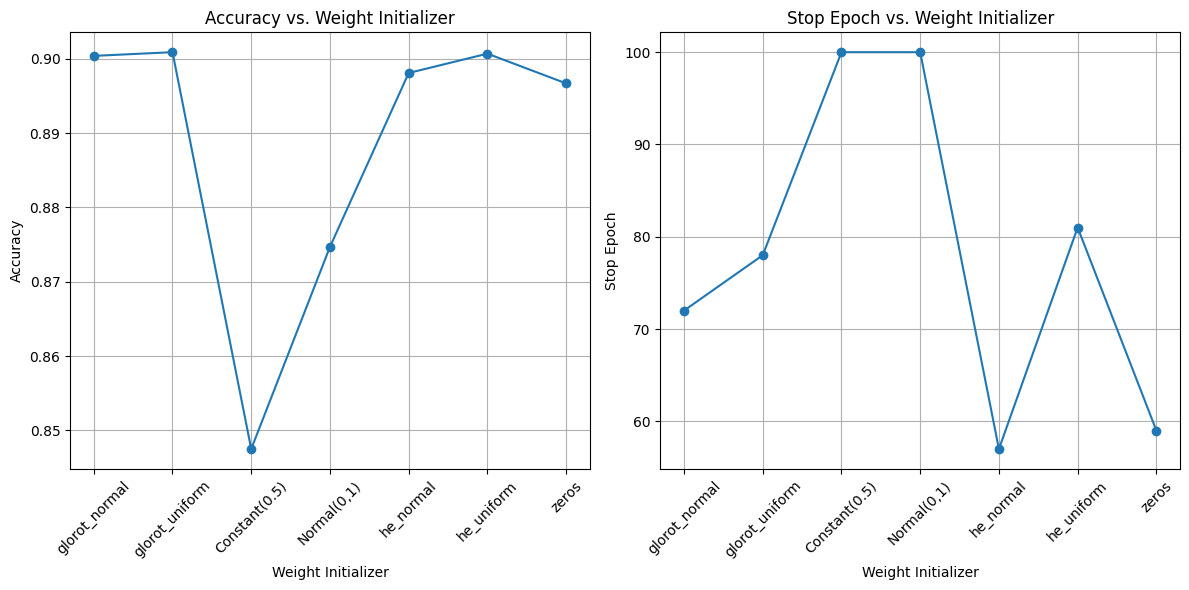

In [ ]:
accuracy_wi={}
for i in range(7):
    loss, accuracy = model_wi[i].evaluate(test_img, sparse_test_label)
    accuracy_wi[i] = accuracy

accuracy_values = [accuracy_wi[i] for i in range(7)]
stop_epochs = [epoch_wi[i] for i in range(7)]

weight_init = ['glorot_normal', 'glorot_uniform', 'Constant(0.5)', 'Normal(0,1)', 'he_normal', 'he_uniform', 'zeros']
helper.acc_epoch_graph (weight_init, 'Weight Initializer', accuracy_values, stop_epochs, log=False, rot=True)

En general, todas la inicializaciones tienen un accuracy similar, con la excepción de la constante y la normal, las cuales son muy inferiores. Esta diferencia también se ve reflejada en los pesos. Debido a que la he_normal suele ser utilizada para redes con función de activación relu, sumado a los buenos resultados ya obtenidos con glorot normal, se optó por continuar utilizando éste último inicializador.

###Mejor Modelo

####Data Augmentation

In [5]:
train_img_flip = np.flip(train_img, axis=2)

train_img_aug = np.concatenate([train_img, train_img_flip])
train_labels_aug = np.concatenate([sparse_train_label, sparse_train_label])

####Modelo

In [ ]:
best_model = Sequential()
learning_rate = 0.00125
batch_size= 256
optimizer = Adam
activation = 'softplus'
dropout_rate = 0.3
batch_normalization = True
weight_init = 'glorot_normal'
epochs=100

best_model.add(Flatten(input_shape=(28, 28)))
best_model.add(Dense(512, activation = activation, kernel_initializer = weight_init))
best_model.add(Dropout(dropout_rate))
best_model.add(Dense(256, activation = activation, kernel_initializer = weight_init))
best_model.add(Dropout(dropout_rate))

if (batch_normalization): best_model.add(BatchNormalization())
best_model.add(Dense(10, activation='softmax'))

early_stop = EarlyStopping(monitor='val_accuracy', patience=10)

best_model.summary()


best_model.compile(loss='categorical_crossentropy', optimizer= optimizer (learning_rate=learning_rate), metrics=['accuracy'])
history = best_model.fit(train_img_aug, train_labels_aug, validation_data=(val_img, sparse_val_label), epochs=epochs, batch_size = batch_size, callbacks = [early_stop])



Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_27 (Flatten)        (None, 784)               0         
                                                                 
 dense_77 (Dense)            (None, 512)               401920    
                                                                 
 dropout_46 (Dropout)        (None, 512)               0         
                                                                 
 dense_78 (Dense)            (None, 256)               131328    
                                                                 
 dropout_47 (Dropout)        (None, 256)               0         
                                                                 
 batch_normalization_23 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                     

In [ ]:
loss, accuracy = best_model.evaluate(test_img, sparse_test_label)

313/313 [==============================] - 1s 2ms/step - loss: 0.3663 - accuracy: 0.9038


Puede notarse que realmente se hizo una **mejora del modelo respecto al original**, debido al análisis de los diferentes hiperparámetros. 

##3 - Decision Boundary

In [ ]:
new_model = Sequential()
learning_rate = 0.00125
batch_size= 256
optimizer = Adam
activation = 'softplus'
dropout_rate = 0.3
batch_normalization = True
weight_init = 'glorot_normal'
epochs=100

new_model.add(Flatten(input_shape=(28, 28)))
new_model.add(Dense(512, activation = activation, kernel_initializer = weight_init))
new_model.add(Dropout(dropout_rate))
new_model.add(Dense(256, activation = activation, kernel_initializer = weight_init))
new_model.add(Dropout(dropout_rate))
new_model.add(Dense(2, activation = activation))
if (batch_normalization): best_model.add(BatchNormalization())
new_model.add(Dense(10, activation='softmax'))

early_stop = EarlyStopping(monitor='val_accuracy', patience=10)

new_model.compile(loss='categorical_crossentropy', optimizer= optimizer (learning_rate=learning_rate), metrics=['accuracy'])
history = new_model.fit(train_img_aug, train_labels_aug, validation_data=(val_img, sparse_val_label), epochs=epochs, batch_size = batch_size, callbacks = [early_stop], verbose=False)


31250/31250 [==============================] - 41s 1ms/step


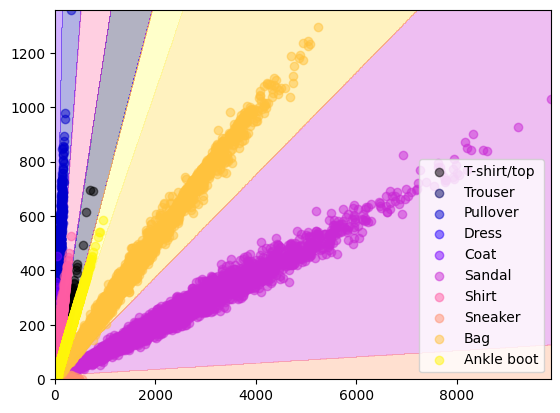

In [ ]:
def plot_DB(model, img, label):
    # Intermediate layer output
    intermediate_output = model.layers[-2].output
    submodel = Model(model.input, intermediate_output)
    internal_data = submodel.predict(img)

    # Grid boundaries
    x_min, x_max = np.min(internal_data[:, 0]), np.max(internal_data[:, 0])
    y_min, y_max = np.min(internal_data[:, 1]), np.max(internal_data[:, 1])

    # Grid points
    num_points = 1000
    x_grid = np.linspace(x_min, x_max, num_points)
    y_grid = np.linspace(y_min, y_max, num_points)
    X_grid, Y_grid = np.meshgrid(x_grid, y_grid)
    grid_points = np.c_[X_grid.reshape(-1), Y_grid.reshape(-1)]  # Flatten

    # Predict labels for grid points
    softmax_output = model.layers[-1].output
    softmax_model = Model(model.layers[-1].input, softmax_output)
    predicted_labels = np.argmax(softmax_model.predict(grid_points), axis=1)
    predicted_labels = predicted_labels.reshape(X_grid.shape)

    # Plot decision boundary
    plt.contourf(X_grid, Y_grid, predicted_labels, 10, cmap=plt.cm.gnuplot2, alpha=0.3)

    # Plot samples
    for class_label in range(10):
        class_indices = np.where(label == class_label)[0]
        plt.scatter(internal_data[class_indices, 0], internal_data[class_indices, 1],
                    alpha=0.5, color=plt.cm.gnuplot2(class_label / 10), label=class_names[class_label])

    plt.legend()
    plt.show()

plot_DB(new_model, train_img, train_label)


Se puede observar como las diferentes clases son **linealmente separables**. A su vez tambien se puede ver que, tal como se mencionó previamente los **calzados** son mas **simples de distinguir**.

##4 - Eliminación de pesos

In [8]:
!pip install lottery-ticket-pruner
from lottery_ticket_pruner import LotteryTicketPruner, PrunerCallback

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
# Red_1
red_1 = Sequential()
red_1.add(Flatten(input_shape=(28, 28)))
red_1.add(Dense(256, activation='softplus', kernel_initializer=None))
red_1.add(Dropout(0.3))
red_1.add(Dense(128, activation='softplus', kernel_initializer=None))
red_1.add(Dropout(0.3))
red_1.add(BatchNormalization())
red_1.add(Dense(10, activation='softmax'))
red_1.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.00125), metrics=['accuracy'])

initial_weights = red_1.get_weights()
pruner = LotteryTicketPruner(red_1)

_, accuracy1 = red_1.evaluate(test_img, sparse_test_label)

313/313 [==============================] - 3s 7ms/step - loss: 3.5648 - accuracy: 0.1000


In [10]:
# Red_2
early_stop = EarlyStopping(monitor='val_accuracy', patience=10)
history2 = red_1.fit(train_img_aug, train_labels_aug, validation_data=(val_img, sparse_val_label), epochs=20, batch_size=256, callbacks=[early_stop], verbose = False)

pruner.set_pretrained_weights(red_1)
_, accuracy2 = red_1.evaluate(test_img, sparse_test_label)
initial_weights2 = red_1.get_weights()

313/313 [==============================] - 1s 3ms/step - loss: 0.3238 - accuracy: 0.8862


In [11]:
# Red_3
red_1.set_weights(initial_weights)
pruner.calc_prune_mask(red_1, 0.5, 'large_final')
untrained_loss, untrained_accuracy = red_1.evaluate(test_img, sparse_test_label)
history2 = red_1.fit(train_img_aug, train_labels_aug, validation_data=(val_img, sparse_val_label), epochs=20, batch_size=256, callbacks=[early_stop, PrunerCallback(pruner)], verbose=False)
trained_loss, trained_accuracy = red_1.evaluate(test_img, sparse_test_label)

313/313 [==============================] - 1s 3ms/step - loss: 0.3042 - accuracy: 0.8937


In [12]:
print("Red 1 (sin train):", accuracy1)
print("Red 2 (entrenada):", accuracy2)
print("Red 3 (sin train):", untrained_accuracy)
print("Red 3 (entrenada):", trained_accuracy)

Red 1 (sin train): 0.10000000149011612
Red 2 (entrenada): 0.8862000107765198
Red 3 (sin train): 0.10000000149011612
Red 3 (entrenada): 0.8937000036239624


Se puede notar que hubo una mejora en el accuracy luego de haber aplicado prunning. Tenerse en cuenta que el valor de accuracy puede parecer bajo, debido a que se disminuyó el número de epochs para mayor velocidad.